In [1]:
import os
from collections import deque
import itertools
import datetime
import pytz
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import tqdm
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import multiprocessing
import quantstats as qs

ModuleNotFoundError: No module named 'quantstats'

In [ ]:
qs.extend_pandas()

# Global Variables

In [ ]:
DATA_DIR = "../data/parquet"

# Modeling

Preprocess/postprocess

base

In [3]:
class Preprocessor():
    def preprocess(self, data):
        raise NotImplementedError("All classes inheriting from Preprocessor class need to implement the 'preprocess' method!")    

In [4]:
class Postprocessor():
    def postprocess(self, data):
        raise NotImplementedError("All classes inheriting from Postprocessor class need to implement the 'postprocess' method!")    

In [8]:
preprocessor = Preprocessor

kucoin

In [6]:
class KucoinPreprocessor(Preprocessor):
    def preprocess(self, data):
        symbol = data["topic"].split(":")[1].split("_")[0]
        data = {
            "o": float(data["data"]["candles"][1]),
            "c": float(data["data"]["candles"][2]),
            "h": float(data["data"]["candles"][3]),
            "l": float(data["data"]["candles"][4]),
            "v": float(data["data"]["candles"][5]),
        }
        return symbol, data

In [7]:
class KucoinPostprocessor(Postprocessor):
    def postprocess(self, strategy_name, symbol, position):
        return {"strategy_name": strategy_name, "symbol": symbol, "position": position}

universe

In [225]:
class Universe():
    def __init__(self, name, data_source_type, data_source_url, start_datetime, end_datetime, interval, datetime_format, instrument_list=None):
        self.name=name
        self.data={}
        self.start_datetime=start_datetime
        self.end_datetime=end_datetime
        self.interval=interval
        self.datetime_format=datetime_format
        self.instrument_list=instrument_list
        self.data_source_type=data_source_type
        self.data_source_url=data_source_url
        self.allowed_data_source_types=("parquet")
        self.allowed_datetime_formats={"date": "%Y-%m-%d", "datetime": "%Y-%m-%d %H:%M:%S"}
        self.__validate_datetime_format
    
    def __validate_datetime_format(self):
        if self.datetime_format not in self.allowed_datetime_formats:
            raise ValueError("datetime_format can only be the following: {}".format(tuple(self.allowed_datetime_formats.keys())))
    
    def load(self):
        if self.data_source_type == "csv":
            raise NotImplementedError("Current system accepts only parquet!")
        elif self.data_source_type == "parquet":
            self.load_parquet_data()
        elif self.data_source_type == "database":
            raise NotImplementedError("Current system accepts only parquet!")
        else:
            raise ValueError("Invalid data_source_type specified! Allowed data source types are: {}".format(self.allowed_data_source_types))
    
    def load_parquet_data(self):
        rule = {
            "o": "first",
            "h": "max",
            "l": "min",
            "c": "last",
            "v": "sum",
            "a": "sum"
        }
        datetime.datetime.strptime("2021-01-01", "%Y-%m-%d")
        # If self.instrument_list is not specified, assume loading all symbols
        if self.instrument_list is None:
            instrument_list = self.get_all_instruments_from_directory()
            self.instrument_list = instrument_list
        else:
            instrument_list = self.instrument_list
        start_datetime_object = datetime.datetime.strptime(
            self.start_datetime, self.allowed_datetime_formats[self.datetime_format]
        )
        end_datetime_object = datetime.datetime.strptime(
            self.end_datetime, self.allowed_datetime_formats[self.datetime_format]
        )
        # Need add 1 day as if date is specified, will only take at time 00:00:00
        # E.g. if end_datetime is 2021-01-31, date will be taken only up till 2021-01-31 00:00:00
        # but the subsequent time belonging to 2021-01-31 will be ignored. Hence, time delta is added
        # and as a result, the filtering function subsequently look for lesser than rather than
        # lesser than or equals to
        end_datetime_object += datetime.timedelta(days=1)
        pbar = tqdm.tqdm(instrument_list)
        for symbol in pbar:
            pbar.set_description("Loading parquet data for {}".format(symbol))
            df = pd.read_parquet(self.data_source_url + "/" + symbol + "_" + self.interval + ".parquet")
            df = self.utc_to_datetime_index_conversion(df)
            df = df.loc[(df.index.to_pydatetime() >= start_datetime_object) & (df.index.to_pydatetime() < end_datetime_object)]
            df = df.resample(self.interval).agg(rule)
            df = self.create_custom_columns(df)
            self.data[symbol] = df
    
    def create_custom_columns(self, df):
        # Custom values derived from raw
        # p represents p&l which is the difference between current closing price and previous period closing price        
        df["p"] = df["c"].diff()
        # r represents the returns percentage via decimals which is the (current closing price - previous closing price) / previous closing price 
        df["r"] = df["c"].pct_change()
        # d represents spread between the highest price and lowest price
        df["d"] = df["h"] - df["l"]
        # s represents the spread between the open and closing price
        df["s"] = df["c"] - df["o"]
        return df
    
    def get_all_instruments_from_directory(self):
        all_instrument_files = os.listdir(self.data_source_url)
        return list(map(lambda x : x.split('_')[0], all_instrument_files))
    
    def utc_to_datetime_index_conversion(self, df):
        df.index = df.index.map(lambda x : datetime.datetime.fromtimestamp(x))
        return df            

Strategy

In [226]:
class Strategy():
    def __init__(self, name, env, preprocessor, postprocessor, max_data_length=None):
        self.name=name
        self.env=env
        self.preprocessor=preprocessor
        self.postprocessor=postprocessor
        self.max_data_length=max_data_length
        self.symbols={}
        self.allowed_envs=("test", "prod")
        # Run validation on init
        self.__validate_env()
    
    def __validate_env(self):
        if self.env not in self.allowed_envs:
            raise ValueError("Specified env is not allowed. Allowed envs: {}".format(self.allowed_envs))
            
    def __init_symbol_data(self):
        if self.max_data_length is not None:
            return {"data": { "o": deque([], self.max_data_length),
                              "h": deque([], self.max_data_length),
                              "l": deque([], self.max_data_length),
                              "c": deque([], self.max_data_length),
                              "v": deque([], self.max_data_length)},
                    "position": 0}
        else:
            return {"data": { "o": deque([]),
                              "h": deque([]),
                              "l": deque([]),
                              "c": deque([]),
                              "v": deque([])},
                    "position": 0}
    
    def run(self, data):
        symbol, processed_data = self.preprocessor.preprocess(data)
        self.update(symbol, processed_data)
        current_position = self.symbols[symbol]["position"]
        new_position = self.execute(symbol, current_position)
        if new_position is not None:
            self.symbols[symbol]["position"] = new_position
        postprocessed_data = self.postprocessor.postprocess(self.name, symbol, new_position)
        return postprocessed_data
    
    def update(self, symbol, data):
        #  Create data structure if needed
        if symbol not in self.symbols:
            # Basic init
            self.symbols[symbol] = self.__init_symbol_data()
            # Additional features init
            additional_features_init = self.__init_additional_features()
            if additional_features_init is not None:
                self.symbols[symbol].update(additional_features_init)
        # Basic data will be ohlcv
        self.symbols[symbol]["data"]["o"].append(data["o"])
        self.symbols[symbol]["data"]["h"].append(data["h"])
        self.symbols[symbol]["data"]["l"].append(data["l"])
        self.symbols[symbol]["data"]["c"].append(data["c"])
        self.symbols[symbol]["data"]["v"].append(data["v"])
        # If need additional features
        additional_features = self.generate_additional_features(data)
        if additional_features is not None:
            for feature in additional_features:
                self.symbols[symbol]["data"][feature].append(additional_features[feature])
        
    def execute(self, symbol, position):
        if position == 1:
            new_position = self.short_position_rule(symbol)
        else:
            new_position = self.long_position_rule(symbol)
        return new_position
    
    def long_position_rule(self, symbol):
        raise NotImplementedError("All classes inheriting from Strategy class need to implement the 'long_position_rule' method!")
    
    def short_position_rule(self, symbol):
        raise NotImplementedError("All classes inheriting from Strategy class need to implement the 'short_position_rule' method!")
    
    # If additional features required to store for time period, use the bottom 2 method to do so
    def __init_additional_features(self):
        """Initialization of additional features
        """
        return None
    
    def generate_additional_features(self, data):
        return None

In [227]:
class SimpleMovingAverageStrategy(Strategy):
    def __init__(self, name, env, preprocessor, postprocessor, sma_long_duration, sma_short_duration, price_type="c"):
        # max_data_length is sma_long_duration
        super().__init__(name, env, preprocessor, postprocessor, sma_long_duration)
        self.sma_short_duration=sma_short_duration
        self.sma_long_duration=sma_long_duration
        self.price_type=price_type
    
    def calculate_sma(self, symbol):
        # Calculate sma for both duration and perform update
        short_sma = sum(itertools.islice(self.symbols[symbol]["data"][self.price_type], self.sma_long_duration - self.sma_short_duration, self.sma_long_duration)) / self.sma_short_duration
        long_sma = sum(self.symbols[symbol]["data"][self.price_type]) / self.sma_long_duration
        return short_sma, long_sma

    def long_position_rule(self, symbol):
        if len(self.symbols[symbol]["data"][self.price_type]) != self.sma_long_duration:
            return None
        short_sma, long_sma = self.calculate_sma(symbol)
        if short_sma > long_sma:
            return 1
        else:
            return None
    
    def short_position_rule(self, symbol):
        if len(self.symbols[symbol]["data"][self.price_type]) != self.sma_long_duration:
            return None
        short_sma, long_sma = self.calculate_sma(symbol)
        if short_sma < long_sma:
            return 0
        else:
            return None

Make Portfolio object

Portfolio Template dict store for metrics

In [228]:
{
    "strat1": { 
        "metrics": {},
        "universe": {
            "kucoin": {
                "metrics": {},
                "symbols": {
                    "ADA-USDT": {
                        "metrics": {},
                        "position": {}
                    }
                }
            }
        }
    }
}

{'strat1': {'metrics': {},
  'universe': {'kucoin': {'metrics': {},
    'symbols': {'ADA-USDT': {'metrics': {}, 'position': {}}}}}}}

In [229]:
class Portfolio():
    def __init__(self, name, env, auto_balance):
        self.name=name
        self.env=env
        self.auto_balance=auto_balance
        self.strategies={}
        self.allowed_envs=("test", "prod")
        # Validate env
        self.__validate_env()
        
    def __validate_env(self):
        if self.env not in self.allowed_envs:
            raise ValueError("Specified env is not allowed. Allowed envs: {}".format(self.allowed_envs))
        
    def register_strategy(self, strategy_name):
        if strategy_name in self.strategies:
            raise ValueError("Strategy name already exist in portfolio! Please use a different strategy name!")
        self.strategies[strategy_name] = {"weight": 0, "metrics": {}, "universe": {}}
        if self.auto_balance:
            for strategy in self.strategies:
                self.strategies[strategy]["weight"] = 1 / len(self.strategies)
    
    def remove_strategy(self, strategy_name):
        if not strategy_name in self.strategies:
            raise ValueError("Unable to find strategy name: {}. Existing strategy names are: {}".format(strategy_name, self.strategies))
        self.strategies.pop(strategy_name)
        if self.auto_balance:
            for strategy in self.strategies:
                self.strategies[strategy]["weight"] = 1 / len(self.strategies)
        
    def update_weights(self, new_weights):
        if len(self.weights) != len(new_weights):
            raise ValueError("New weights specified are of different length commpared to existing weights. Ensure new weights specified matches the number of strategies present in portfolio!")
        self.weights = new_weights
        
    def update_position(self, position_json):
        strategy_name, universe_name, symbol, position = (
            position_json["strategy_name"],
            position_json["universe_name"],
            position_json["symbol"],
            position_json["position"]
        )
        if universe_name not in self.strategies[strategy_name]["universe"]:
            self.strategies[strategy_name]["universe"][universe_name] = {"metrics": {}, "symbols": {}}
        if symbol not in self.strategies[strategy_name]["universe"][universe_name]["symbols"]:
            self.strategies[strategy_name]["universe"][universe_name]["symbols"][symbol] = {"position": [], "metrics": {}}
        if position is None:
            if self.strategies[strategy_name]["universe"][universe_name]["symbols"][symbol]["position"]:
                position = self.strategies[strategy_name]["universe"][universe_name]["symbols"][symbol]["position"][-1]
            else:
                position = 0
        self.strategies[strategy_name]["universe"][universe_name]["symbols"][symbol]["position"].append(position)

Universe json constructor

In [230]:
class KucoinJsonConstructor():
    def construct_json(self, symbol, index, row, period):
        if period == "1min":
            seconds_to_minus = int(index.timestamp()) - 60
        return {
            "type":"message",
            "topic":"/market/candles:{}_{}".format(symbol, period),
            "subject":"trade.candles.update",
            "data":{
                "symbol":symbol, # symbol
                "candles":[
                    str(seconds_to_minus), # Start time of candle cycle
                    str(row["o"]), # open price
                    str(row["c"]), # close price
                    str(row["h"]), # high price
                    str(row["l"]), # low price
                    str(row["v"]), # Transaction volume
                    "268280.09830877" # Transaction amount (dummy as only kucoin provides this)
                ],
                "time": int(index.timestamp())
            }
        }

Make metrics calculator

In [231]:
class MetricsCalculator():
    def __init__(self):
        self.allowed_returns_level=("strategy", "universe", "symbol")

    def run_simple(self, strat_returns, returns, returns_level, start_backtest_datetime_string, strategy_name, universe_name, symbols_name, risk_free_rate, mode, compounded, periods_per_year, database_url, tearsheet_directory, output_returns=False):
        strat_cumulative_returns = self.calculate_cumulative_strategy_returns(strat_returns)
        cumulative_returns = self.calculate_cumulative_returns(returns)
        # Generate results and save
        self.generate_results_simple(strat_returns, returns, returns_level, start_backtest_datetime_string, strategy_name, universe_name, symbols_name, risk_free_rate, mode, compounded, periods_per_year, database_url, tearsheet_directory)
        if output_returns:
            return returns, cumulative_returns, strat_returns, strat_cumulative_returns
    
    ### Helpers ###
    def calculate_strategy_returns(self, returns, positions):
        return np.array(returns) * np.array(positions)
    
    def calculate_cumulative_strategy_returns(self, strategy_returns):
        return np.array(strategy_returns).cumsum()
    
    def calculate_returns(self, prices):
        price = np.array(prices)
        return np.nan_to_num(np.diff(prices)) / prices[1:]
    
    def calculate_cumulative_returns(self, returns):
        return np.array(returns).cumsum()
    
    def generate_results_simple(self, strat_returns, benchmark_returns, returns_level, start_backtest_datetime_string, strategy_name, universe_name, symbols_name, risk_free_rate, mode, compounded, periods_per_year, database_url, tearsheet_directory):
        # Create directory if needed
        self.__create_tearsheet_directory(tearsheet_directory, start_backtest_datetime_string)
        # Create necessary filename and plot title
        plot_title = self.__create_tearsheet_plot_title(
            start_backtest_datetime_string,
            strategy_name,
            universe_name,
            symbols_name
        )
        tearsheet_filename = self.__create_tearsheet_filename(
            start_backtest_datetime_string,
            strategy_name,
            universe_name,
            symbols_name
        )
        self.generate_results_tearsheet_simple(strat_returns, benchmark_returns, start_backtest_datetime_string, risk_free_rate, compounded, periods_per_year, plot_title, tearsheet_directory, tearsheet_filename)
        self.generate_results_database_simple(strat_returns, benchmark_returns, returns_level, start_backtest_datetime_string, strategy_name, universe_name, symbols_name, risk_free_rate, mode, compounded, periods_per_year, database_url, tearsheet_directory, tearsheet_filename)
    
    def generate_results_tearsheet_simple(self, strat_returns, benchmark_returns, start_backtest_datetime_string, risk_free_rate, compounded, periods_per_year, plot_title, tearsheet_directory, tearsheet_filename):
        # Output argument will cause it to write directly rather than to trigger a web download.
        # If download_filename and output specified, output is priortised
        qs.reports.html(
            returns=strat_returns,
            benchmark=benchmark_returns,
            rf=risk_free_rate,
            title=plot_title,
            compounded=compounded,
            periods_per_year=periods_per_year,
            download_filename=tearsheet_filename,
            output=tearsheet_directory + "/" + start_backtest_datetime_string + "/" + tearsheet_filename,
            grayscale=False,
            figfmt='svg',
            template_path=None,
            match_dates=False,
        )

    def generate_results_database_simple(self, strat_returns, benchmark_returns, returns_level, start_backtest_datetime_string, strategy_name, universe_name, symbols_name, risk_free_rate, mode, compounded, periods_per_year, database_url, tearsheet_directory, tearsheet_filename):
        metrics_df = qs.reports.metrics(
            returns=pd.DataFrame(strat_returns),
            benchmark=pd.DataFrame(benchmark_returns),
            rf=risk_free_rate,
            mode=mode,
            compounded=compounded,
            periods_per_year=periods_per_year,
            display=False,
            sep=False,
            prepare_returns=True,
            match_dates=False,
        )
        metrics_df_transposed = metrics_df.T
        # Step 1: Extract the Strategy and Benchmark row separately
        strategy_metrics = metrics_df_transposed.loc["Strategy"]
        benchmark_metrics = metrics_df_transposed.loc["Benchmark"]
        # Step 2: Convert both to dataframes
        strategy_metrics_df = pd.DataFrame(strategy_metrics)
        benchmark_metrics_df = pd.DataFrame(benchmark_metrics)
        # Step 3: Given extraction of these data changes them to Series, transposed them
        strategy_metrics_df = strategy_metrics_df.T
        benchmark_metrics_df = benchmark_metrics_df.T
        # Step 4: Rename column headers to include "Strategy" or "Benchmark" for identification
        strategy_metrics_df.columns = ["Strategy_" + i  for i in strategy_metrics_df.columns]
        benchmark_metrics_df.columns = ["Benchmark_" + i for i in benchmark_metrics_df.columns]
        # Step 5: reset_index as there is "Strategy" or "Benchmark" in the index and drop the column generated from resetting
        strategy_metrics_df = strategy_metrics_df.reset_index().drop(columns=["index"])
        benchmark_metrics_df = benchmark_metrics_df.reset_index().drop(columns=["index"])
        # Step 6: Combine the 2 dataframes together
        metrics_df = pd.concat([strategy_metrics_df, benchmark_metrics_df], axis=1)
        # Step 7: Create additional columns for meta data
        metrics_df["start_backtest_datetime"] = returns_level
        metrics_df["returns_level"] = returns_level
        metrics_df["strategy_name"] = strategy_name
        metrics_df["universe_name"] = universe_name
        metrics_df["symbols_name"] = symbols_name
        metrics_df["tearsheet_filepath"] = tearsheet_directory + "/" + tearsheet_filename
        # Step 8: Save output
        if database_url.endswith(".csv"):
            if os.path.isfile(database_url):
                database_df = pd.read_csv(database_url)
                database_df = database_df.append(metrics_df, ignore_index=True)
                database_df.to_csv(database_url, index=False)
            else:
                database_df = metrics_df
                database_df.to_csv(database_url)
        else:
            raise NotImplementedError("Only supports csv for now!")

    def __create_tearsheet_directory(self, tearsheet_directory, start_backtest_datetime_string):
        os.makedirs(tearsheet_directory + "/" + start_backtest_datetime_string, exist_ok=True)
        
    def __create_tearsheet_plot_title(self, start_backtest_datetime_string, strategy_name, universe_name, symbols_name):
        plot_title = "({}) Strategy {}".format(start_backtest_datetime_string, strategy_name)
        if universe_name is not None:
            plot_title += " for universe {}".format(universe_name)
            if symbols_name is not None:
                plot_title += " for symbols {}".format(symbols_name)
        plot_title += " tearsheet"
        return plot_title
    
    def __create_tearsheet_filename(self, start_backtest_datetime_string, strategy_name, universe_name, symbols_name):
        tearsheet_filename = f"{start_backtest_datetime_string}_{strategy_name}"
        if universe_name is not None:
            tearsheet_filename += f"_{universe_name}"
            if symbols_name is not None:
                tearsheet_filename += f"_{symbols_name}"
        tearsheet_filename += ".html"
        return tearsheet_filename

Make Backtester

In [232]:
class BacktestSimulator():
    def __init__(self, metrics_database_url, metrics_tearsheet_directory, metrics_mode, metrics_periods_per_year, metrics_risk_free_rate=0.0, metrics_compounded=True):
        self.metrics_database_url=metrics_database_url
        self.metrics_tearsheet_directory=metrics_tearsheet_directory
        self.metrics_mode=metrics_mode
        self.metrics_risk_free_rate=metrics_risk_free_rate
        self.metrics_compounded=metrics_compounded
        self.metrics_periods_per_year=metrics_periods_per_year
        self.portfolio=None
        self.metrics_calculator=MetricsCalculator()
        self.strategy={}
        self.universe={}
        self.universe_json_constructor={}
        # Default attributes
        self.allowed_metrics_mode=("basic", "full")
        self.allowed_metrics_periods_per_year=(12, 252, 365)
        self.datetime_format="%Y%m%d_%H%M%S"
        self.start_backtest_datetime_string=None
        # Validation methods
        self.__validate_metrics_periods_per_year()
        self.__validate_metrics_mode()
        
        
    def register_strategy(self, strategy):
        if strategy.name in self.strategy:
            raise ValueError("Cannot have strategies of the same name! (Duplicated strategy name: {})".format(strategy.name))
        self.strategy[strategy.name] = strategy
        
    def create_portfolio(self, portfolio_name, portfolio_env, autobalance=False):
        self.portfolio = Portfolio(portfolio_name, portfolio_env, autobalance)
        for strategy in self.strategy:
            self.portfolio.register_strategy(strategy)
        
    def __validate_portfolio(self, portfolio):
        assert len(portfolio.strategy_names) == len(portfolio.weights)
    
    def register_universe(self, universe, universe_json_constructor):
        self.universe[universe.name] = universe
        self.universe_json_constructor[universe.name] = universe_json_constructor
        
    def run(self, universe_name=None, symbols=None):
        # Assert all inputs are created first
        self.__validate_inputs()
        # Create datetimestamp
        start_run_datetime = datetime.datetime.now()
        start_run_datetime_string = datetime.datetime.strftime(start_run_datetime, "%Y%m%d_%H%M%S")
        self.start_backtest_datetime_string = start_run_datetime_string
        print("Backtest has started at {}".format(datetime.datetime.strftime(start_run_datetime, "%Y-%m-%d_%H:%M:%S")))
        # Run actual simulation
        if universe_name is None and symbols is None:
            self.run_all_exchanges_and_all_symbols()
        elif universe_name is None and symbols is not None:
            self.run_all_exchanges_and_specific_symbols()
        elif universe_name is not None and symbols is None:
            self.run_specific_exchange_and_all_symbols(universe_name)
        else:
            self.run_specific_exchange_and_specific_symbols(universe_name, symbols)
        # Compute metrics
        print("Generating metrics results...")
        self.generate_metrics_and_save()
        end_run_datetime = datetime.datetime.now()
        print("Backtest has successfully completed at {}".format(datetime.datetime.strftime(end_run_datetime, "%Y-%m-%d_%H:%M:%S")))
            
    def run_all_exchanges_and_all_symbols(self):
        print("All exchanges all symbols backtest mode selected!")
        for universe_name in self.universe:
            for symbol in self.universe[universe_name].data.keys():
                self.run_single(universe_name, symbol)

    def run_all_exchanges_and_specific_symbols(self, symbols):
        print("All exchanges specific symbols backtest mode selected!")
        for universe_name in self.universe:
            for symbol in symbols:
                self.run_single(universe_name, symbol)
    
    def run_specific_exchange_and_all_symbols(self, universe_name):
        print("Specific exchange all symbols backtest mode selected!")
        universe_data = self.universe[universe_name]
        for symbol in self.universe[universe_name].data:
            self.run_single(universe_name, symbol)
            
    def run_specific_exchange_and_specific_symbols(self, universe_name, symbols):
        print("Specific exchanges specific symbols backtest mode selected!")
        for symbol in symbols:
            self.run_single(universe_name, symbol)

    def run_single(self, universe_name, symbol):
        universe_data = self.universe[universe_name].data
        symbol_data = universe_data[symbol]
        strategy_names = list(self.strategy.keys())
        number_of_strategies = len(strategy_names)
        print("Running simulation for universe '{}' on symbol '{}' for all strategies...".format(universe_name, symbol))
        for i in range(len(strategy_names)):
            strategy = strategy_names[i]
            print("Strategy {}/{}".format(i + 1, len(self.strategy.keys())))
            print("Backtesting strategy: '{}'".format(strategy))
            for index, row in tqdm.tqdm(symbol_data.iterrows(), total=len(symbol_data)):
                constructed_json = self.universe_json_constructor[universe_name].construct_json(symbol, index, row, self.universe[universe_name].interval)
                if symbol in self.strategy[strategy].symbols:
                    closing_period_position = self.strategy[strategy].symbols[symbol]["position"]
                else:
                    closing_period_position = None
                position_json = self.strategy[strategy].run(constructed_json)
                position_json["universe_name"] = universe_name
                # Because portfolio tracks position at close while the position json tracks the change in position after close
                # Hence, the portfolio needs to take in the previous position when a change in position occurs
                # As such, replace position_json["position"] with closing_period_position
                position_json["position"] = closing_period_position
                self.portfolio.update_position(position_json)
        print("Finished simulation!")
        print("")

    def generate_metrics_and_save(self):
        # TODO: Calculate weighted metrics ###
        datetime_index = None
        for strategy in self.portfolio.strategies:
            strategy_returns = None
            strategy_cumulative_returns = None
            strategy_strat_returns = None
            strategy_strat_cumulative_returns = None
            for universe_name in self.portfolio.strategies[strategy]["universe"]:
                universe_returns = None
                universe_cumulative_returns = None
                universe_strat_returns = None
                universe_strat_cumulative_returns = None
                # Extract some meta data to be used when generating report for universe level
                universe_interval = self.universe[universe_name].interval
                universe_start_datetime = self.universe[universe_name].start_datetime
                universe_end_datetime = self.universe[universe_name].end_datetime
                universe_datetime_index = pd.date_range(universe_start_datetime, universe_end_datetime, freq=universe_interval)
                for symbol in self.portfolio.strategies[strategy]["universe"][universe_name]["symbols"]:
                    symbol_data = self.universe[universe_name].data[symbol]
                    symbol_datetime_indexes = symbol_data.index
                    if datetime_index is None:
                        datetime_index = symbol_datetime_indexes
                    returns = np.nan_to_num(symbol_data["r"])
                    strat_positions = self.portfolio.strategies[strategy]["universe"][universe_name]["symbols"][symbol]["position"]
                    strat_returns = self.metrics_calculator.calculate_strategy_returns(returns, strat_positions)
                    returns = pd.Series(returns, index=datetime_index)
                    strat_returns = pd.Series(strat_returns, index=datetime_index)
                    # Generate metrics and save for symbol level results
                    returns, cumulative_returns, strat_returns, strat_cumulative_returns  =\
                        self.metrics_calculator.run_simple(
                            strat_returns=strat_returns,
                            returns=returns,
                            returns_level="symbol",
                            start_backtest_datetime_string=self.start_backtest_datetime_string,
                            strategy_name=strategy,
                            universe_name=universe_name,
                            symbols_name=symbol,
                            risk_free_rate=self.metrics_risk_free_rate,
                            mode=self.metrics_mode,
                            compounded=self.metrics_compounded,
                            periods_per_year=self.metrics_periods_per_year,
                            database_url=self.metrics_database_url,
                            tearsheet_directory=self.metrics_tearsheet_directory,
                            output_returns=True
                    )
                    # Add to universe for both buy and hold returns and strat returns
                    self.portfolio.strategies[strategy]["universe"][universe_name]["symbols"][symbol]["metrics"]["returns"] = returns
                    self.portfolio.strategies[strategy]["universe"][universe_name]["symbols"][symbol]["metrics"]["strat_returns"] = strat_returns
                    self.portfolio.strategies[strategy]["universe"][universe_name]["symbols"][symbol]["metrics"]["cum_returns"] = cumulative_returns
                    self.portfolio.strategies[strategy]["universe"][universe_name]["symbols"][symbol]["metrics"]["strat_cum_returns"] = strat_cumulative_returns
                    # Formula is simple addition to get cumulative
                    if universe_returns is None:
                        universe_returns = np.array(returns)
                    else:
                        universe_returns = universe_returns + np.array(returns)
                    if universe_cumulative_returns is None:
                        universe_cumulative_returns = np.array(cumulative_returns)
                    else:
                        universe_cumulative_returns = universe_cumulative_returns + np.array(cumulative_returns)
                    if universe_strat_returns is None:
                        universe_strat_returns = np.array(strat_returns)
                    else:
                        universe_strat_returns = universe_strat_returns + np.array(strat_returns)
                    if universe_strat_cumulative_returns is None:
                        universe_strat_cumulative_returns = np.array(strat_cumulative_returns)
                    else:
                        universe_strat_cumulative_returns = universe_strat_cumulative_returns + np.array(strat_cumulative_returns)
                # Calcuate metrics for universe level returns
                self.metrics_calculator.run_simple(
                        strat_returns=pd.Series(universe_strat_returns, index=datetime_index),
                        returns=pd.Series(universe_returns, index=datetime_index),
                        returns_level="universe",
                        start_backtest_datetime_string=self.start_backtest_datetime_string,
                        strategy_name=strategy,
                        universe_name=universe_name,
                        symbols_name=None,
                        risk_free_rate=self.metrics_risk_free_rate,
                        mode=self.metrics_mode,
                        compounded=self.metrics_compounded,
                        periods_per_year=self.metrics_periods_per_year,
                        database_url=self.metrics_database_url,
                        tearsheet_directory=self.metrics_tearsheet_directory,
                        output_returns=False
                )
                # Create universe returns
                self.portfolio.strategies[strategy]["universe"][universe_name]["metrics"]["returns"] = universe_returns
                self.portfolio.strategies[strategy]["universe"][universe_name]["metrics"]["cum_returns"] = universe_cumulative_returns
                self.portfolio.strategies[strategy]["universe"][universe_name]["metrics"]["strat_returns"] = universe_strat_returns
                self.portfolio.strategies[strategy]["universe"][universe_name]["metrics"]["strat_cum_returns"] = universe_strat_cumulative_returns
                # Add to strategy for both buy and hold returns and strat returns
                # Formula is simple addition to get cumulative
                if strategy_returns is None:
                    strategy_returns = np.array(universe_returns)
                else:
                    strategy_returns = strategy_returns + np.array(universe_returns)
                if strategy_cumulative_returns is None:
                    strategy_cumulative_returns = np.array(universe_cumulative_returns)
                else:
                    strategy_cumulative_returns = strategy_cumulative_returns + np.array(universe_cumulative_returns)
                if strategy_strat_returns is None:
                    strategy_strat_returns = np.array(universe_strat_returns)
                else:
                    strategy_strat_returns = strategy_strat_returns + np.array(universe_strat_returns)
                if strategy_strat_cumulative_returns is None:
                    strategy_strat_cumulative_returns = np.array(universe_strat_cumulative_returns)
                else:
                    strategy_strat_cumulative_returns = strategy_strat_cumulative_returns + np.array(universe_strat_cumulative_returns)
            # Calcuate metrics for strategy level returns
            self.metrics_calculator.run_simple(
                    strat_returns=pd.Series(strategy_strat_returns, index=datetime_index),
                    returns=pd.Series(strategy_returns, index=datetime_index),
                    returns_level="strategy",
                    start_backtest_datetime_string=self.start_backtest_datetime_string,
                    strategy_name=strategy,
                    universe_name=None,
                    symbols_name=None,
                    risk_free_rate=self.metrics_risk_free_rate,
                    mode=self.metrics_mode,
                    compounded=self.metrics_compounded,
                    periods_per_year=self.metrics_periods_per_year,
                    database_url=self.metrics_database_url,
                    tearsheet_directory=self.metrics_tearsheet_directory,
                    output_returns=False
            )
            # Create strategy returns
            self.portfolio.strategies[strategy]["metrics"]["returns"] = strategy_returns
            self.portfolio.strategies[strategy]["metrics"]["cum_returns"] = strategy_cumulative_returns
            self.portfolio.strategies[strategy]["metrics"]["strat_returns"] = strategy_strat_returns
            self.portfolio.strategies[strategy]["metrics"]["strat_cum_returns"] = strategy_strat_cumulative_returns

    def get_exchanges(self):
        return [self.exchanges[i].name for i in self.exchanges]

    def __validate_inputs(self):
        try:
            assert len(self.strategy.keys()) > 0, "No strategy was loaded into the environment! Please ensure at least one strategy is loaded into the enivornment!"
            assert len(self.universe.keys()) > 0, "No universe data was loaded into the environment! Please ensure at least one data source is loaded into the enivornment!"
            assert self.portfolio is not None, "No portfolio was created! Please create portfolio before running simulation!"
        except AssertionError as err:
            print(err)
            
    def __validate_metrics_mode(self):
        if self.metrics_mode not in self.allowed_metrics_mode:
            raise ValueError("Invalid metrics_mode specified! Allowed values are: {}".format(self.allowed_metrics_mode))
            
    def __validate_metrics_periods_per_year(self):
        if self.metrics_periods_per_year not in self.allowed_metrics_periods_per_year:
            raise ValueError("Invalid metrics_periods_per_year specified! Allowed values are: {}".format(self.allowed_metrics_periods_per_year))

Test

Confirm "ADA-USDT", "BTC-USDT", "ETH-USDT", "LUNA-USDT", "LTC-USDT", "QNT-USDT"

* can't find "DCH-USDT"

In [233]:
instrument_list = ["ADA-USDT", "BTC-USDT", "ETH-USDT", "LUNA-USDT", "LTC-USDT", "QNT-USDT", "ONE-USDT"]
universe = Universe("kucoin_candlestick", "parquet", DATA_DIR, "2021-01-01", "2021-11-15", "1min", "date", instrument_list)
universe.load()

Loading parquet data for ETH-USDT: 100%|█████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.75s/it]


In [224]:
kucoin_preprocessor = KucoinPreprocessor()
kucoin_postprocessor = KucoinPostprocessor()
sma_strat_1 = SimpleMovingAverageStrategy("SMA", "test", kucoin_preprocessor, kucoin_postprocessor, 100, 10)
# sma_strat_2 = SimpleMovingAverageStrategy("SMA-2", "test", kucoin_preprocessor, kucoin_postprocessor, 120, 10)
# sma_strat_3 = SimpleMovingAverageStrategy("SMA-3", "test", kucoin_preprocessor, kucoin_postprocessor, 120, 20)
backtest = BacktestSimulation(
    metrics_database_url="../data/backtest/backtest.csv",
    metrics_tearsheet_directory="../data/backtest/tearsheets",
    metrics_mode="full",
    metrics_periods_per_year=365,
    metrics_risk_free_rate=0.0,
    metrics_compounded=True
)
backtest.register_strategy(sma_strat_1)
# backtest.register_strategy(sma_strat_2)
# backtest.register_strategy(sma_strat_3)
backtest.register_universe(universe, KucoinJsonConstructor())
backtest.create_portfolio("Test SMA", "test", True)
# for symbol in instrument_list:
#     backtest.run_single("kucoin_candlestick", symbol)
backtest.run(universe_name="kucoin_candlestick", symbols=instrument_list)

Backtest has started at 2022-01-21_21:49:01
Specific exchanges specific symbols backtest mode selected!
Running simulation for universe 'kucoin_candlestick' on symbol 'BTC-USDT' for all strategies...
Strategy 1/1
Backtesting strategy: 'SMA'


100%|███████████████████████████████████████████████████████████████████████| 459360/459360 [00:30<00:00, 14876.47it/s]


Finished simulation!

Running simulation for universe 'kucoin_candlestick' on symbol 'ETH-USDT' for all strategies...
Strategy 1/1
Backtesting strategy: 'SMA'


100%|███████████████████████████████████████████████████████████████████████| 459360/459360 [00:30<00:00, 15098.46it/s]


Finished simulation!

Generating metrics results...
Backtest has successfully completed at 2022-01-21_21:57:37


In [214]:
backtest.portfolio.strategies["SMA"]["universe"]["kucoin_candlestick"]["symbols"]["BTC-USDT"]["metrics"]["returns"]
backtest.portfolio.strategies["SMA"]["universe"]["kucoin_candlestick"]["symbols"]["BTC-USDT"]["metrics"]["strat_returns"]

timestamp
2021-01-01 00:00:00    0.000000
2021-01-01 00:01:00   -0.003189
2021-01-01 00:02:00   -0.000936
2021-01-01 00:03:00   -0.000084
2021-01-01 00:04:00    0.000725
                         ...   
2021-11-15 23:55:00    0.001972
2021-11-15 23:56:00   -0.001366
2021-11-15 23:57:00   -0.000149
2021-11-15 23:58:00   -0.000502
2021-11-15 23:59:00   -0.000945
Freq: T, Length: 459360, dtype: float32

In [218]:
backtest.portfolio.strategies["SMA"]["universe"]["kucoin_candlestick"]["metrics"]

{}

In [204]:
for symbol in backtest.portfolio.strategies["SMA"]["universe"]["kucoin_candlestick"]["symbols"]:
    symbol_data = backtest.universe["kucoin_candlestick"].data[symbol]
    symbol_datetime_indexes = symbol_data.index
    returns = np.nan_to_num(symbol_data["r"])
    strat_positions = backtest.portfolio.strategies["SMA"]["universe"]["kucoin_candlestick"]["symbols"][symbol]["position"]
    strat_returns = backtest.metrics_calculator.calculate_strategy_returns(returns, strat_positions)
    returns = pd.Series(returns, index=symbol_datetime_indexes)
    strat_returns = pd.Series(strat_returns, index=symbol_datetime_indexes)
    # Generate metrics and save for symbol level results
    returns, cumulative_returns, strat_returns, strat_cumulative_returns  =\
        backtest.metrics_calculator.run_simple(
            strat_returns=strat_returns,
            returns=returns,
            returns_level="symbol",
            start_backtest_datetime_string=backtest.start_backtest_datetime_string,
            strategy_name="SMA",
            universe_name="kucoin_candlestick",
            symbols_name=symbol,
            risk_free_rate=backtest.metrics_risk_free_rate,
            mode="full",
            compounded=backtest.metrics_compounded,
            periods_per_year=backtest.metrics_periods_per_year,
            database_url=backtest.metrics_database_url,
            tearsheet_directory=backtest.metrics_tearsheet_directory + "/" + backtest.start_backtest_datetime_string,
            output_returns=True
    )

NameError: name 'mode' is not defined

In [ ]:
strat_returns

In [200]:
qs.reports.html(
    returns=stock,
    benchmark=returns,
    rf=0.0,
    title="test",
    compounded=True,
    periods_per_year=365,
    download_filename="test.html",
#     output="../data/test.html",
    grayscale=False,
    figfmt='svg',
    template_path=None,
    match_dates=False,
)

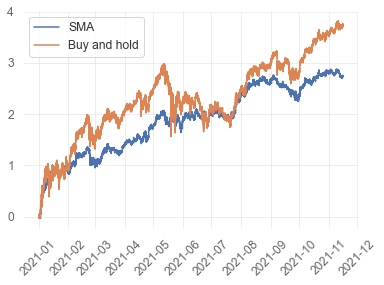

In [71]:
strat_cum_returns = backtest.portfolio.strategies["SMA"]["metrics"]["strat_cum_returns"]
cum_returns = backtest.portfolio.strategies["SMA"]["metrics"]["cum_returns"]
plt.plot(universe.data["BTC-USDT"].index, strat_cum_returns, label="SMA")
# plt.plot(universe.data["ADA-USDT"].index, strat_cum_returns_2, label="SMA-2")
# plt.plot(universe.data["ADA-USDT"].index, strat_cum_returns_3, label="SMA-3")
plt.plot(universe.data["BTC-USDT"].index, cum_returns, label="Buy and hold")
plt.xticks(rotation=45)
plt.legend()
plt.show()

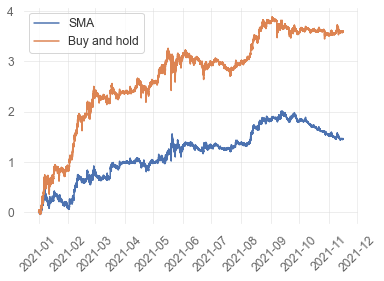

In [18]:
strat_cum_returns = backtest.portfolio.strategies["SMA"]["metrics"]["kucoin_candlestick"]["ADA-USDT"]["strat_cum_returns"]
# strat_cum_returns_2 = backtest.portfolio.strategies["SMA-2"]["metrics"]["kucoin_candlestick"]["ADA-USDT"]["strat_cum_returns"]
# strat_cum_returns_3 = backtest.portfolio.strategies["SMA-3"]["metrics"]["kucoin_candlestick"]["ADA-USDT"]["strat_cum_returns"]
cum_returns = backtest.portfolio.strategies["SMA"]["metrics"]["kucoin_candlestick"]["ADA-USDT"]["cum_returns"]
plt.plot(universe.data["ADA-USDT"].index, strat_cum_returns, label="SMA")
# plt.plot(universe.data["ADA-USDT"].index, strat_cum_returns_2, label="SMA-2")
# plt.plot(universe.data["ADA-USDT"].index, strat_cum_returns_3, label="SMA-3")
plt.plot(universe.data["ADA-USDT"].index, cum_returns, label="Buy and hold")
plt.xticks(rotation=45)
plt.legend()
plt.show()

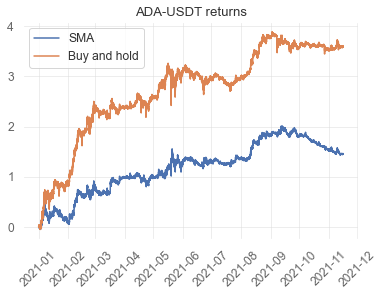

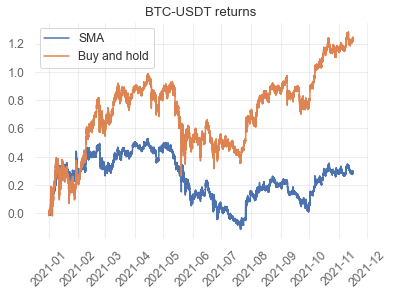

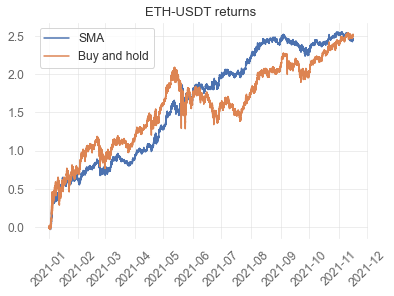

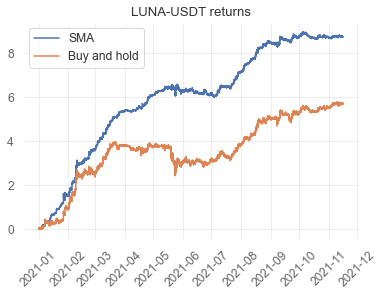

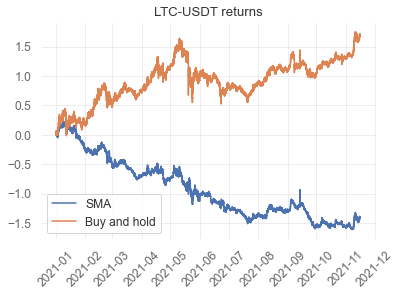

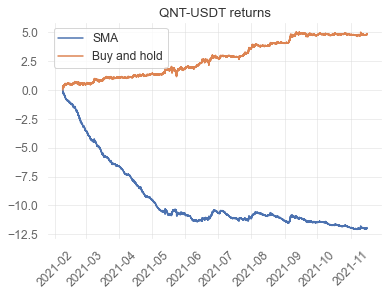

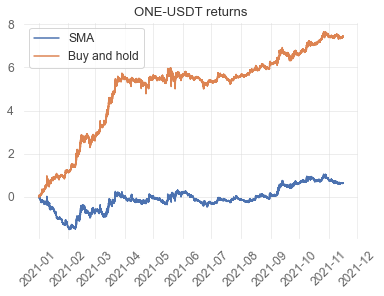

In [19]:
for symbol in instrument_list:
    strat_cum_returns = backtest.portfolio.strategies["SMA"]["metrics"]["kucoin_candlestick"][symbol]["strat_cum_returns"]
    cum_returns = backtest.portfolio.strategies["SMA"]["metrics"]["kucoin_candlestick"][symbol]["cum_returns"]
    plt.plot(universe.data[symbol].index, strat_cum_returns, label="SMA")
    plt.plot(universe.data[symbol].index, cum_returns, label="Buy and hold")
    plt.xticks(rotation=45)
    plt.legend()
    plt.title("{} returns".format(symbol))
    plt.show()

In [107]:
symbol = "BTC-USDT"
strat_returns = backtest.portfolio.strategies["SMA"]["universe"]["kucoin_candlestick"]["symbols"][symbol]["metrics"]["strat_returns"]
benchmark = universe.data[symbol]["r"]

returns_series = pd.Series(strat_returns, index=universe.data["BTC-USDT"].index)
return_series = returns_series.resample("1D").agg("sum")
return_series.index = return_series.index.rename("Date")

benchmark = benchmark.resample("1D").agg("sum")
benchmark.index = benchmark.index.rename("Date")

qs.reports.html(return_series, benchmark=benchmark, output="../test.jpg")

In [84]:
a = qs.reports.metrics(return_series, benchmark=benchmark, prepare_returns=False, periods_per_year=365, display=False, mode="full")
a

,Strategy,Benchmark
Start Period,2021-01-01,2021-01-01
End Period,2021-11-15,2021-11-15
Risk-Free Rate,0.0,0.0
Time in Market,1.0,1.0
Cumulative Return,0.15,1.33
...,...,...
Win Month %,0.55,0.64
Win Quarter %,0.75,0.75
Win Year %,1.0,1.0
Beta,0.52,-


In [81]:
a = qs.reports.metrics(return_series, benchmark=benchmark, prepare_returns=False, periods_per_year=365, display=False)
a_transposed = a.T
strategy_metrics = a_transposed.loc["Strategy"]
benchmark_metrics = a_transposed.loc["Benchmark"]
strategy_metrics_df = pd.DataFrame(strategy_metrics)
benchmark_metrics_df = pd.DataFrame(benchmark_metrics)

strategy_metrics_df = strategy_metrics_df.T
benchmark_metrics_df = benchmark_metrics_df.T

strategy_metrics_df.columns = ["Strategy_" + i  for i in strategy_metrics_df.columns]
benchmark_metrics_df.columns = ["Benchmark_" + i for i in benchmark_metrics_df.columns]

strategy_metrics_df = strategy_metrics_df.reset_index().drop(columns=["index"])
benchmark_metrics_df = benchmark_metrics_df.reset_index().drop(columns=["index"])

metrics_df = pd.concat([strategy_metrics_df, benchmark_metrics_df], axis=1)

In [104]:
metrics_df

,Strategy_Start Period,Strategy_End Period,Strategy_Risk-Free Rate,Strategy_Time in Market,Strategy_Cumulative Return,Strategy_CAGR﹪,Strategy_Sharpe,Strategy_Sortino,Strategy_Sortino/√2,Strategy_Omega,...,Benchmark_1Y,Benchmark_3Y (ann.),Benchmark_5Y (ann.),Benchmark_10Y (ann.),Benchmark_All-time (ann.),Benchmark_Avg. Drawdown,Benchmark_Avg. Drawdown Days,Benchmark_Recovery Factor,Benchmark_Ulcer Index,Benchmark_Serenity Index
0,2021-01-01,2021-11-15,0.0,1.0,"2,492.64",7921.87,6.96,18.03,12.75,3.2,...,77.36,148.3,148.3,148.3,148.3,-0.13,13,100.72,0.36,26.19


In [271]:
stock = qs.utils.download_returns('FB')

In [299]:
return_series

Date
2021-01-01     -8.431820
2021-01-02    -38.745837
2021-01-03    -17.926423
2021-01-04    145.486363
2021-01-05    278.844395
                 ...    
2021-11-11    683.388320
2021-11-12    630.934729
2021-11-13    620.062481
2021-11-14    614.956408
2021-11-15      0.416139
Freq: D, Length: 319, dtype: float64

In [273]:
qs.reports.html(stock, "FB")

In [13]:
symbol = "ADA-USDT"
all_outputs = []
for i in range(universe[symbol].shape[0]):
    row = universe[symbol].iloc[i]
    index = universe[symbol].index[i]
    row_kucoin_format = construct_kucoin_kline(symbol, index, row, "1min")
    output = sma_strat.run(row_kucoin_format)
    if output is None:
        all_outputs.append({})
    else:
        all_outputs.append(output)

NameError: name 'universe' is not defined

# Archived

In [24]:
from collections import deque

In [33]:
class VolumeHypeStrat():
    def __init__(self, number_of_increasing_points_threshold, number_of_std_threshold, number_of_periods_long_term):
        self.number_of_increasing_points_threshold=number_of_increasing_points_threshold
        self.number_of_std_threshold=number_of_std_threshold
        self.number_of_periods_long_term=number_of_periods_long_term
        self.universe=None
    
    def create_universe(self, universe):
        self.universe = {i: {"closing_price_data": deque(), "volume_data": deque(), "highest_trending_volume": 0, "exceed_threshold_counts": 0, "position": 0} for i in universe.keys()}
    
    def generate_position(self, data):
        # Extract data from incoming json
        timing, open_price, close_price, high_price, low_price, volume, amount = data["candles"]
        symbol = data["symbol"]
        # Calculate volume standard deviation from existing
        std = np.std(self.universe[symbol]["volume_data"])
        # Step 1: Check if volume is anomalous (greater than number_of_std_threshold of sliding window)
        if (volume > (np.mean(self.universe[symbol]["volume_data"]) + self.number_of_std_threshold * std)) and (close_price > self.universe[symbol]["closing_price_data"][-1]):
            self.universe[symbol]["exceed_threshold_counts"] += 1
            self.universe[symbol]["highest_trending_volume"] = volume
        # Step 1.2: If not greater, reset to 0
        else:
            self.universe[symbol]["exceed_threshold_counts"] = 0
            self.universe[symbol]["highest_trending_volume"] = 0
        if (self.universe[symbol]["exceed_threshold_counts"] > self.number_of_increasing_points_threshold) and (self.universe[symbol]["exceed_threshold_counts"]["position"] == 0):
            self.universe[symbol]["exceed_threshold_counts"]["position"] = 1
            return {"symbol": symbol, "position": 1}
        else:
            return None
        
        
    def update(self, data):
        # Pop oldest data
        self.universe[symbol]["volume_data"].popleft()
        self.universe[symbol]["closing_price_data"].popleft()
        # Update latest data
        self.universe[symbol]["volume_data"].append(volume)
        self.universe[symbol]["closing_price_data"].append(close_price)
        
        

In [40]:
np.std(deque([1,2,3]))

0.816496580927726

In [34]:
strat = VolumeHypeStrat(3, 2, 30)

In [35]:
strat.create_universe(universe)

In [21]:
list(filter(lambda x : x.startswith("ETH"), list(universe.keys())))

['ETH-BTC',
 'ETH-DAI',
 'ETH-PAX',
 'ETH-TUSD',
 'ETH-USDC',
 'ETH-USDT',
 'ETH-UST',
 'ETH2-ETH',
 'ETH3L-USDT',
 'ETH3S-USDT',
 'ETHO-BTC',
 'ETHO-USDT']

In [ ]:
visualize_single_candlestick(universe, "ALGO-USDT", "2021-01-15", "2021-02-28")